# Pré-processamento de Dados e Análise Exploratória

Este notebook documenta o processo de pré-processamento dos dados meteorológicos e de geração de energia solar. As etapas incluem limpeza, transformação e preparação dos dados para análise e modelagem. Este processo é fundamental para garantir a qualidade e a consistência dos dados, permitindo a realização de análises precisas e o desenvolvimento de modelos preditivos robustos.



## Importação de Bibliotecas Necessárias

In [14]:
import os # Biblioteca para manipulação de arquivos e diretórios
import sys # Biblioteca para manipulação de caminhos do sistema
import pandas as pd # Biblioteca para manipulação de dataframes
import numpy as np # Biblioteca para manipulação de vetores e matrizes
import geopandas as gpd # Biblioteca para manipulação de geodataframes
import matplotlib.pyplot as plt # Biblioteca para plotar gráficos
import seaborn as sns # Biblioteca para plotar gráficos

from sklearn.impute import SimpleImputer # Função para imputação de valores faltantes
from sklearn.preprocessing import MinMaxScaler # Função para normalização dos dados

# Ajuste do sys.path para incluir o diretório src
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

# Importar funções específicas do projeto
from data_preprocessing import *
from database import create_connection, query_data

## Carregar Dados

In [15]:
# Carregar base de dados
current_dir = os.getcwd()  # Diretório de trabalho atual, que é dentro de 'data'
repository_dir = os.path.abspath(os.path.join(current_dir, '..'))  # Voltar um nível para o diretório do repositório
file_path = os.path.join(repository_dir, 'data', 'processed', 'base_de_dados.csv')
df = pd.read_csv(file_path, delimiter=',')

display(df.head())

,data_hora_completa,ceg,estacao,radiacao_global,temperatura_ar,umidade_relativa,velocidade_vento,val_geracao
0,2023-01-31 00:00:00,UFV.RS.MG.040851-4.01,ARAXA,NaN,"19,9",85.0,",3",0.0
1,2023-01-31 01:00:00,UFV.RS.MG.040851-4.01,ARAXA,NaN,"19,4",89.0,"1,8",0.0
2,2023-01-31 02:00:00,UFV.RS.MG.040851-4.01,ARAXA,NaN,"19,6",83.0,"1,2",0.0
3,2023-01-31 03:00:00,UFV.RS.MG.040851-4.01,ARAXA,NaN,"19,9",81.0,",7",0.0
4,2023-01-31 04:00:00,UFV.RS.MG.040851-4.01,ARAXA,NaN,"19,8",79.0,",1",0.0


## Limpeza dos Dados
Nesta seção, realizamos a limpeza dos dados, como remoção de valores ausentes, definição adequada de tipos e etc.

In [16]:
# Removendo colunas que não serão utilizadas no tratamento data_hora_completa, ceg, estacao)
df_numeric = df.iloc[:, 3:]

# Display
display(df_numeric.head())

,radiacao_global,temperatura_ar,umidade_relativa,velocidade_vento,val_geracao
0,NaN,"19,9",85.0,",3",0.0
1,NaN,"19,4",89.0,"1,8",0.0
2,NaN,"19,6",83.0,"1,2",0.0
3,NaN,"19,9",81.0,",7",0.0
4,NaN,"19,8",79.0,",1",0.0


In [17]:
# Substituir vírgula por ponto e transformar em float
df_numeric = df_numeric.apply(lambda x: x.str.replace(',', '.') if x.dtype == 'object' else x)
df_numeric = df_numeric.astype(float)

# Display
display(df_numeric.head())


,radiacao_global,temperatura_ar,umidade_relativa,velocidade_vento,val_geracao
0,NaN,19.9,85.0,0.3,0.0
1,NaN,19.4,89.0,1.8,0.0
2,NaN,19.6,83.0,1.2,0.0
3,NaN,19.9,81.0,0.7,0.0
4,NaN,19.8,79.0,0.1,0.0


### Inputação de Dados Faltantes

In [18]:
# Substitua -9999 por NaN
df_numeric.replace(-9999, np.nan, inplace=True)

# Criação do objeto imputer
imputer = SimpleImputer(strategy='most_frequent')

# Ajuste do objeto
imputer.fit(df_numeric)

# Aplicação da imputação
df_numeric = pd.DataFrame(imputer.transform(df_numeric), columns=df_numeric.columns)

# Display
display(df_numeric.head())

,radiacao_global,temperatura_ar,umidade_relativa,velocidade_vento,val_geracao
0,0.2,19.9,85.0,0.3,0.0
1,0.2,19.4,89.0,1.8,0.0
2,0.2,19.6,83.0,1.2,0.0
3,0.2,19.9,81.0,0.7,0.0
4,0.2,19.8,79.0,0.1,0.0


## Análise Exploratória dos Dados

Realizamos análises exploratórias para entender os dados e identificar padrões.

In [19]:
# join df_numeric com as colunas data_hora_completa, ceg e estacao
df = df.iloc[:, :3].join(df_numeric)

# transformar data em datetime
df['data_hora_completa'] = pd.to_datetime(df['data_hora_completa'], format='%Y-%m-%d %H:%M:%S')

# Display
display(df.head())

,data_hora_completa,ceg,estacao,radiacao_global,temperatura_ar,umidade_relativa,velocidade_vento,val_geracao
0,2023-01-31 00:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.2,19.9,85.0,0.3,0.0
1,2023-01-31 01:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.2,19.4,89.0,1.8,0.0
2,2023-01-31 02:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.2,19.6,83.0,1.2,0.0
3,2023-01-31 03:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.2,19.9,81.0,0.7,0.0
4,2023-01-31 04:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.2,19.8,79.0,0.1,0.0


<Figure size 1200x800 with 0 Axes>

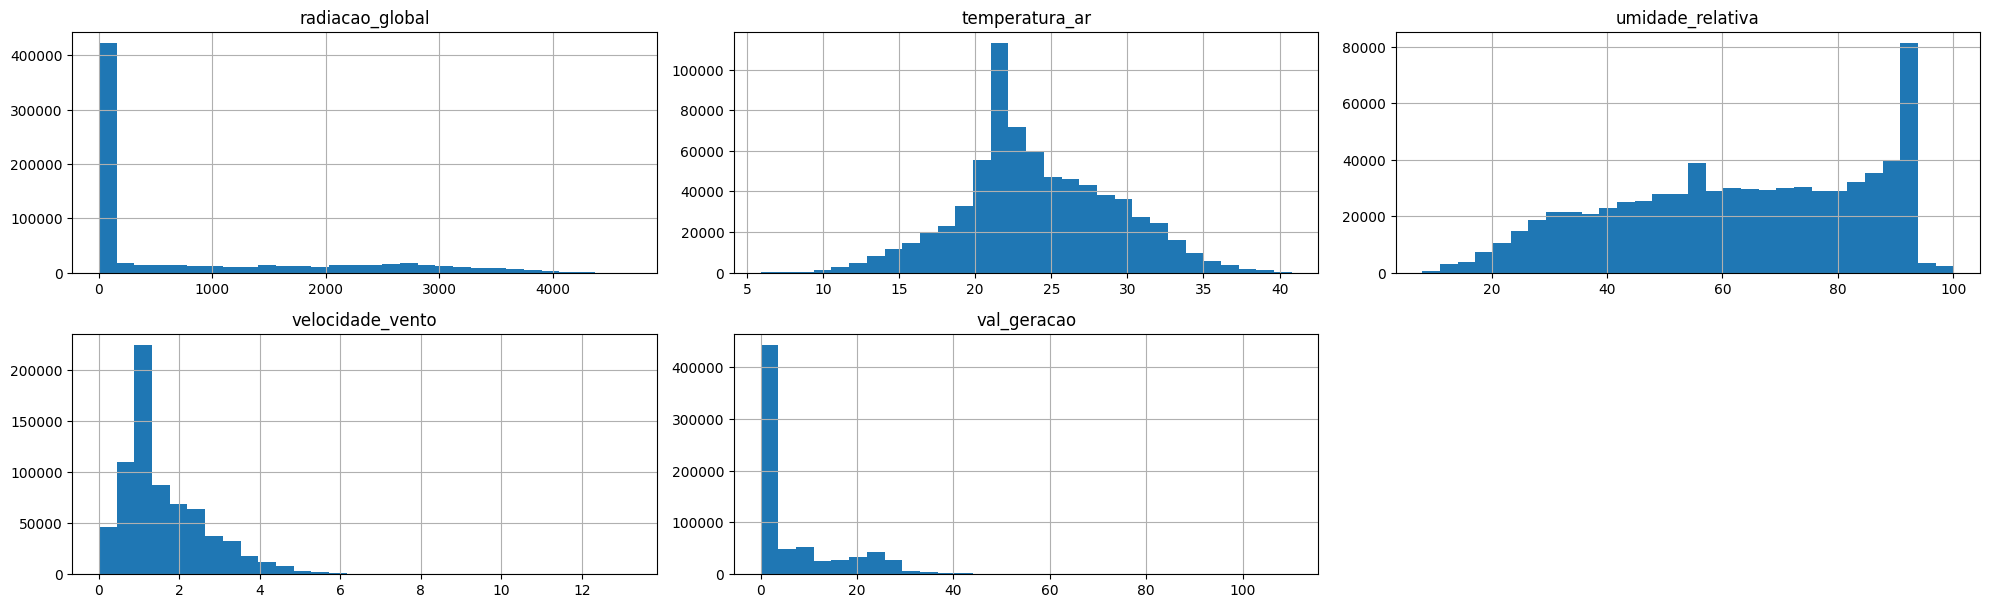

In [20]:
# Plotar a distribuição das variáveis
plt.figure(figsize=(12, 8))
df.iloc[:, 3:].hist(bins=30, figsize=(20, 15), layout=(5, 3))
plt.tight_layout()
plt.show()

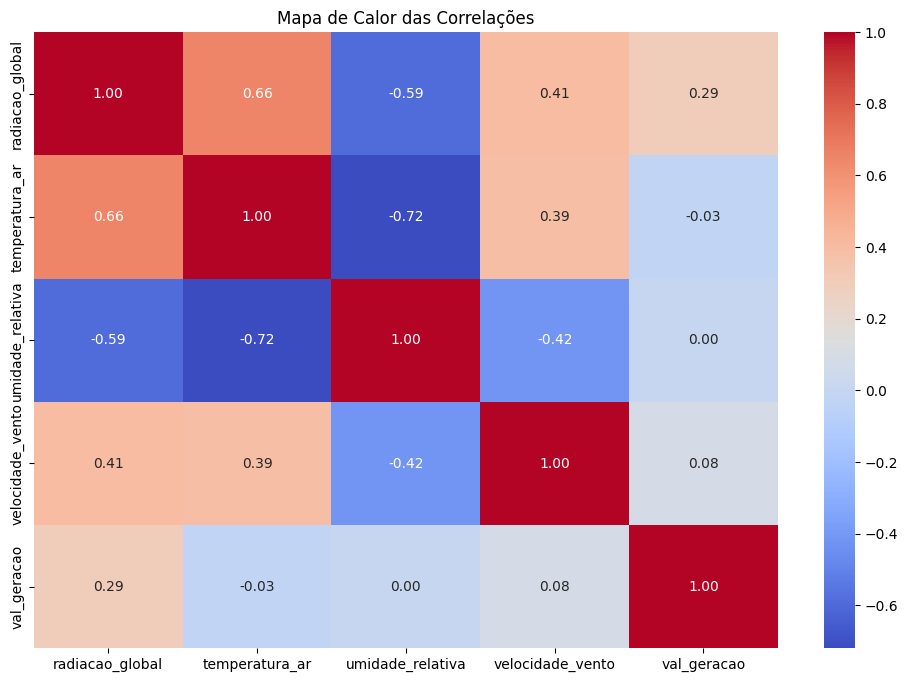

In [21]:
# Plotar o mapa de calor das correlações
plt.figure(figsize=(12, 8))
sns.heatmap(df.iloc[:, 3:].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor das Correlações')
plt.show()

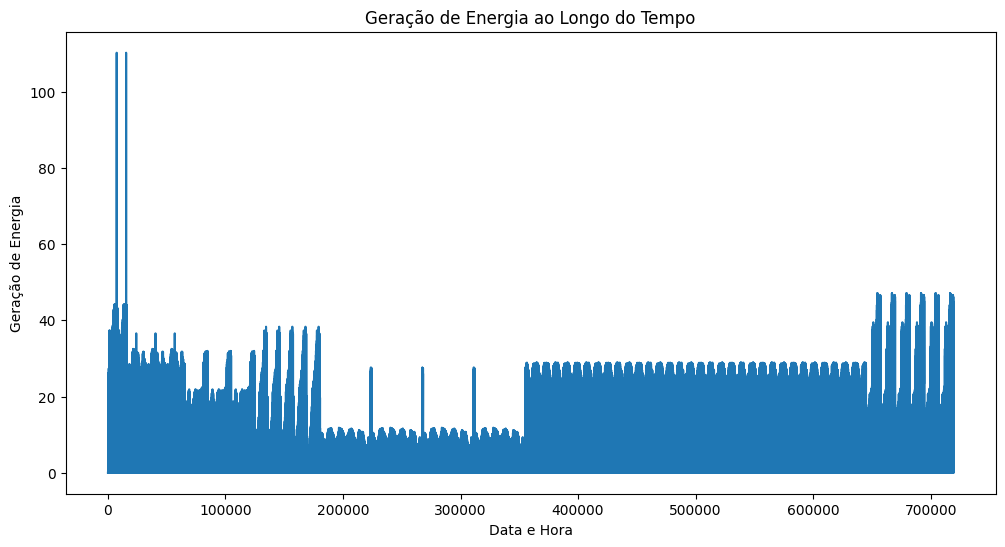

In [22]:
plt.figure(figsize=(12, 6))
df.iloc[:, 3:]['val_geracao'].plot()
plt.title('Geração de Energia ao Longo do Tempo')
plt.xlabel('Data e Hora')
plt.ylabel('Geração de Energia')
plt.show()

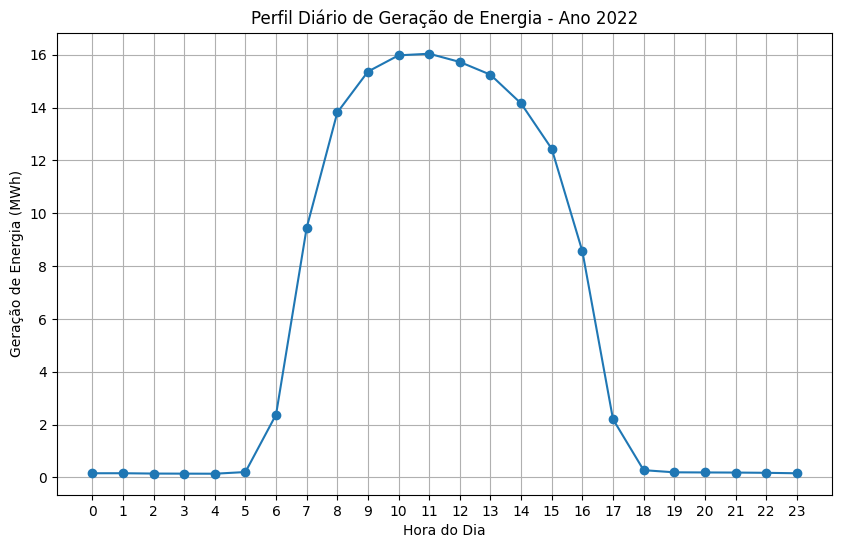

In [23]:
# Escolher um ano para plotar o perfil diário de geração de energia
year = 2022
energy_col = 'val_geracao'

# Filtrar os dados para o ano escolhido
df_year = df[df['data_hora_completa'].dt.year == year]

# Agrupar por hora do dia e calcular a média da geração de energia
df_daily_profile = df_year.groupby(df_year['data_hora_completa'].dt.hour)[energy_col].mean()

# Plotar o perfil diário
plt.figure(figsize=(10, 6))
plt.plot(df_daily_profile.index, df_daily_profile.values, marker='o')
plt.title(f'Perfil Diário de Geração de Energia - Ano {year}')
plt.xlabel('Hora do Dia')
plt.ylabel('Geração de Energia (MWh)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

# Plotar o perfil diário de geração de energia para o ano de 2019
plot_daily_energy_profile(df, year, energy_col)

## Preparação para a modelagem


### Remover Variáveis que Não Auxiliam na Predição

Vamos remover variáveis com variância zero ou quase zero, alta correlação e dependência linear.

In [24]:
# Remover variáveis com variância zero ou quase zero
variancia = df.iloc[:, 3:].var()
low_variance_cols = variancia[variancia < 0.01].index

# Print
print('Variáveis com variância zero ou quase zero:')
print(low_variance_cols)

if len(low_variance_cols) > 0:
    df.drop(columns=low_variance_cols, inplace=True)

# Display
display(df.head())

Variáveis com variância zero ou quase zero:
Index([], dtype='object')


,data_hora_completa,ceg,estacao,radiacao_global,temperatura_ar,umidade_relativa,velocidade_vento,val_geracao
0,2023-01-31 00:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.2,19.9,85.0,0.3,0.0
1,2023-01-31 01:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.2,19.4,89.0,1.8,0.0
2,2023-01-31 02:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.2,19.6,83.0,1.2,0.0
3,2023-01-31 03:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.2,19.9,81.0,0.7,0.0
4,2023-01-31 04:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.2,19.8,79.0,0.1,0.0


### Remover Variáveis com Alta Correlação
Removeremos uma das variáveis para cada par de variáveis altamente correlacionadas.

In [25]:
# Calcular a matriz de correlação
corr_matrix = df.iloc[:, 3:].corr().abs()

print('Matriz de correlação:')
display(corr_matrix)

# Selecionar o triângulo superior da matriz de correlação
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar índices de colunas com correlação superior a 0.95
high_corr_cols = [column for column in upper.columns if any(upper[column] > 0.75)]

print('Variáveis com alta correlação:')
print(high_corr_cols)

Matriz de correlação:


,radiacao_global,temperatura_ar,umidade_relativa,velocidade_vento,val_geracao
radiacao_global,1.000000,0.657220,0.594429,0.407003,0.288960
temperatura_ar,0.657220,1.000000,0.719297,0.392369,0.026357
umidade_relativa,0.594429,0.719297,1.000000,0.419242,0.003511
velocidade_vento,0.407003,0.392369,0.419242,1.000000,0.082654
val_geracao,0.288960,0.026357,0.003511,0.082654,1.000000


Variáveis com alta correlação:
[]


### Tornar Variáveis Quantitativas mais "Amigáveis"
Normalização dos dados

In [26]:
# Normalização dos dados (intervalo [0, 1])
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df.iloc[:, 3:]), columns=df.columns[3:])

df = df.iloc[:, :3].join(df_normalized)

# Display
display(df.head())

,data_hora_completa,ceg,estacao,radiacao_global,temperatura_ar,umidade_relativa,velocidade_vento,val_geracao
0,2023-01-31 00:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.000043,0.401146,0.836957,0.022727,0.0
1,2023-01-31 01:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.000043,0.386819,0.880435,0.136364,0.0
2,2023-01-31 02:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.000043,0.392550,0.815217,0.090909,0.0
3,2023-01-31 03:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.000043,0.401146,0.793478,0.053030,0.0
4,2023-01-31 04:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.000043,0.398281,0.771739,0.007576,0.0


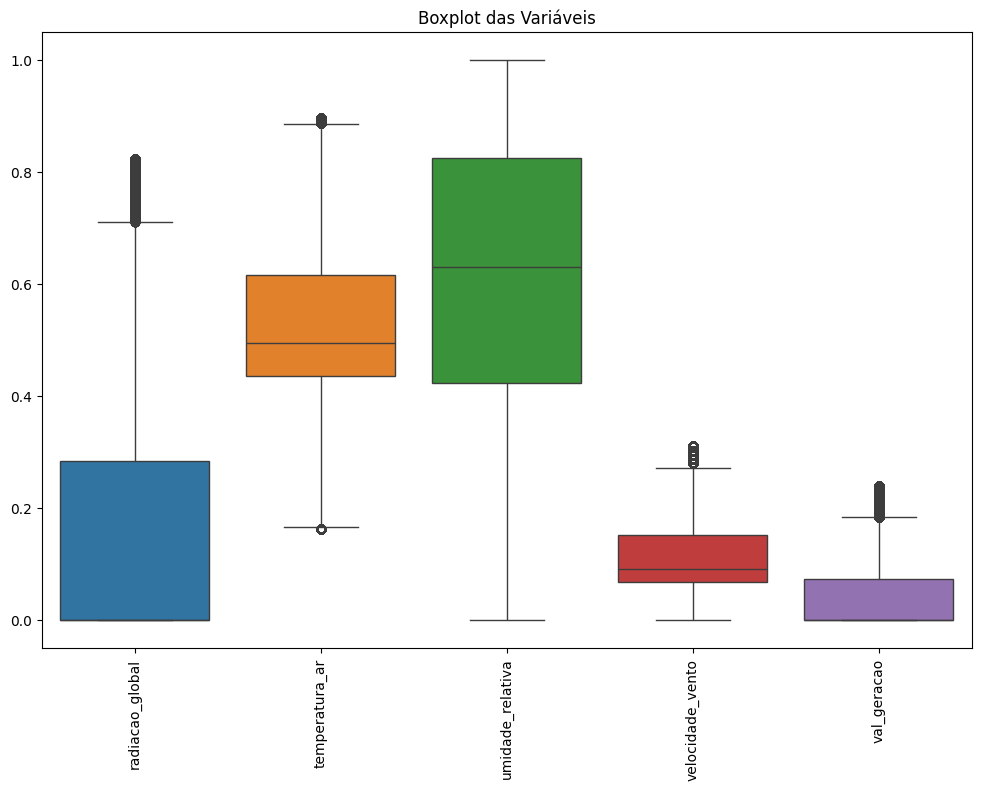

In [27]:
# Remover outliers usando o método IQR (Interquartile Range)
Q1 = df.iloc[:, 3:].quantile(0.25)
Q3 = df.iloc[:, 3:].quantile(0.75)
IQR = Q3 - Q1

# Definir limites para os outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar dados para remover outliers
df = df[~((df.iloc[:, 3:] < lower_bound) | (df.iloc[:, 3:] > upper_bound)).any(axis=1)]

# Plotar boxplots das variáveis
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.title('Boxplot das Variáveis')
plt.xticks(rotation=90)
plt.show()

## Exportar 

In [28]:
caminho = os.path.join(repository_dir, 'data', 'processed', 'base_de_dados_preprocessada.csv')
df.to_csv(caminho, index=False)